<a href="https://colab.research.google.com/github/DhruvaBansal00/ConfidentMT/blob/master/LanguageAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
!ls
%cd drive/My Drive/ConfidentMachineTranslation/flores
!ls
!pwd

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
drive  sample_data
/content/drive/My Drive/ConfidentMachineTranslation/flores
analysis		       FeatureSubsetBinaryClassifers.ipynb
Analysis		       FLORES.ipynb
backward_models		       LanguageAnalysis.ipynb
BoostedBinaryClassifers.ipynb  language_models
checkpoints		       LM_Thresholding.ipynb
ClassificationDataset	       NCD_Analysis.ipynb
configs			       NNClassification.ipynb
data			       noisychannel
data-bin		       NoisyChannel.ipynb
Ensembles		     

In [2]:
pip install fairseq sacrebleu sentencepiece fastBPE sacremoses

     |████████████████████████████████| 307kB 2.7MB/s 
     |████████████████████████████████| 61kB 3.9MB/s 
     |████████████████████████████████| 1.1MB 5.1MB/s 
     |████████████████████████████████| 890kB 12.9MB/s 
  Created wheel for fairseq: filename=fairseq-0.9.0-cp36-cp36m-linux_x86_64.whl size=2021204 sha256=b1b596dec93fed252739207a247cb6d708cf350181903995e1286a0de1f4fc89
  Stored in directory: /root/.cache/pip/wheels/37/3e/1b/0fa30695dcba41e4b0088067fa40f3328d1e8ee78c22cd4766
  Created wheel for fastBPE: filename=fastBPE-0.1.0-cp36-cp36m-linux_x86_64.whl size=481520 sha256=b3fcb60231d3c492bb1ee8994a70233e30c073213390419573f1a61b07ef71b2
  Stored in directory: /root/.cache/pip/wheels/f3/0c/9c/fc62058b4d473a5602bcd3d3edfece796f123875379ea82d79
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=6e59750f2d88c3e01762e324512f15097b594351558e91adcb3aa7522c176dbc
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a501

In [0]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7413 sha256=dbde817fb3feec42ee59bb3f40adce4e9b93abe8942307ae0aee13cc671d0b77
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 26.3 GB  | Proc size: 159.8 MB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB


In [0]:
dataSet = "valid"
fw_model = "Ensembles/April_04.pt"
bw_model = "backward_models/April_17.pt"
lm_model = "language_models/lm/checkpoint_best.pt"

In [4]:
# !rm -rf analysis/
# !mkdir analysis/

!fairseq-generate \
    data-bin/wiki_ne_en_bpe5000/ \
    --source-lang ne --target-lang en \
    --path $fw_model \
    --beam 5 --lenpen 1.2 \
    --gen-subset $dataSet \
    --remove-bpe=sentencepiece \
    --sacrebleu > analysis/fairseqGenerate.data

  0% 0/12 [00:00<?, ?it/s]/pytorch/aten/src/ATen/native/BinaryOps.cpp:66: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


In [0]:
def storeTranslationStatistics():
    from statistics import mean, median 

    bleu_res = open("analysis/fairseqGenerate.data", "r")
    NMT_original = open("analysis/original_sentences.data", "w")
    NMT_ground_truth = open("analysis/ground_truth_sentences.data", "w")
    NMT_output = open("analysis/translated_sentences.data", "w")
    Sentence_stats = open("analysis/logprob_statistics.data", "w")

    translation_id = None
    for line in bleu_res:
        if line.startswith("H-"):
            NMT_output.write(line.split("\t")[2])
        elif line.startswith("T-"):
            NMT_ground_truth.write(line.split("\t")[1])
        elif line.startswith("S-"):
            translation_id = float(line.split("\t")[0].split("-")[1])
            NMT_original.write(line.split("\t")[1])
        elif line.startswith("P-"):
            scores = [float(i) for i in line.split("\t")[1].split(" ")]
            Sentence_stats.write(str(mean(scores))+" "+str(min(scores))+" "+str(median(scores))+" "+str(max(scores))+" "+str(sum(scores))+" "+str(translation_id)+"\n")

    NMT_ground_truth.close()
    NMT_output.close()
    Sentence_stats.close()
    NMT_original.close()



In [0]:
storeTranslationStatistics()
!fairseq-score --sys analysis/translated_sentences.data --ref analysis/ground_truth_sentences.data --sentence-bleu > analysis/scores.data

In [0]:
from itertools import zip_longest
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from numpy import arange
import subprocess
import random
import numpy as np


class Translation:
    def __init__ (self, ref, out, orig, score, trn_id):
        self.reference = ref
        self.translation = out
        self.original = orig
        self.score = score
        self.trn_id = trn_id
    def __repr__(self):
        return str(self.score)

def compute_excluded_included_score (translations, split_index):
    temporary_reference_inclusion = open("analysis/temporary_reference_inclusion.data", "w")
    temporary_output_inclusion = open("analysis/temporary_output_inclusion.data", "w")

    temporary_reference_exclusion = open("analysis/temporary_reference_exclusion.data", "w")
    temporary_output_exclusion = open("analysis/temporary_output_exclusion.data", "w")

    for i in range(len(translations)):
        if i < split_index:
            temporary_reference_exclusion.write(translations[i].reference)
            temporary_output_exclusion.write(translations[i].translation)
        else:
            temporary_reference_inclusion.write(translations[i].reference)
            temporary_output_inclusion.write(translations[i].translation)

    temporary_reference_inclusion.close()
    temporary_output_inclusion.close()
    temporary_reference_exclusion.close()
    temporary_output_exclusion.close()

    !fairseq-score --sys analysis/temporary_output_inclusion.data --ref analysis/temporary_reference_inclusion.data --sacrebleu > analysis/inclusion_result.data
    !fairseq-score --sys analysis/temporary_output_exclusion.data --ref analysis/temporary_reference_exclusion.data --sacrebleu > analysis/exclusion_result.data

    temporary_inclusion_result = open("analysis/inclusion_result.data")
    temporary_exclusion_result = open("analysis/exclusion_result.data")
    inclusion_result_string = [line for line in temporary_inclusion_result][1].split(" ")[2]
    exclusion_result_string = [line for line in temporary_exclusion_result][1].split(" ")[2]

    return float(exclusion_result_string), float(inclusion_result_string)


NMT_ground_truth = open("analysis/ground_truth_sentences.data", "r")
NMT_output = open("analysis/translated_sentences.data", "r")
NMT_original = open("analysis/original_sentences.data", "r")
Sentence_stats = open("analysis/logprob_statistics.data", "r")
Sentence_bleu = open("analysis/scores.data", "r")

next(Sentence_bleu)
files = [NMT_ground_truth, NMT_output, NMT_original, Sentence_stats, Sentence_bleu]
translations = []

for lines in zip_longest(*files, fillvalue=''):
    reference, translation, original, stats, sentence_bleu = lines
    sentence_bleu = float(sentence_bleu.split("BLEU4 = ")[1].split(",")[0])
    stats = stats.strip("\n").split(" ")
    stat_nums = [float(i) for i in stats][:-2]
    stat_nums.append(sentence_bleu)
    stat_nums.extend([0,0,0,0,0,float(stats[-2]),0,0,0,0,0,0,0,0,0,0,0])
    ###buffer for -> (rare_word_in_en, rare_words_in_ne, ne - en, 
    ###longest_repeated_substring_en, longest_repeated_substring_ne, 
    ###fw_score, bw_score, lm_score, . and ; in translation, | in original, . and ; minus |,
    ###unigram_count, bigram_count, trigram_count, length of translation, length of source,
    ###ratio between source and translation length)
    translations.append(Translation(reference, translation, original, stat_nums, float(stats[-1])))


NMT_ground_truth.close()
NMT_output.close()
NMT_original.close()
Sentence_stats.close()
Sentence_bleu.close()

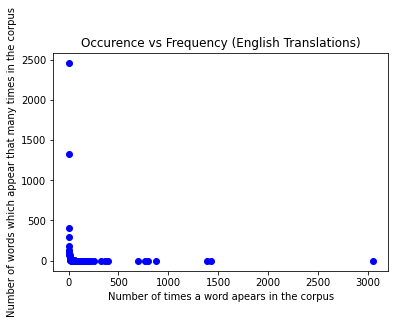

In [8]:
import string

dict_english = {}

for translation in translations:
    english_translation = translation.translation.split()
    for word in english_translation:
        if len(word) > 1:
            word = word.translate(str.maketrans({a:None for a in string.punctuation}))

            if word in dict_english:
                dict_english[word] = 1 + dict_english[word]
            else: 
                dict_english[word] = 1

# for word in dict_english:
#     if dict_english[word] == 1:
#         print(word)

dict_occ_to_freq = {}

for word in dict_english:
    if dict_english[word] in dict_occ_to_freq:
        dict_occ_to_freq[dict_english[word]] = 1 + dict_occ_to_freq[dict_english[word]]
    else: 
        dict_occ_to_freq[dict_english[word]] = 1


x = []
y = []

for occ in dict_occ_to_freq:
    x.append(occ)
    y.append(dict_occ_to_freq[occ])

# print(dict_occ_to_freq[1])

plt.xlabel('Number of times a word apears in the corpus') 
plt.ylabel('Number of words which appear that many times in the corpus') 
plt.title('Occurence vs Frequency (English Translations)')
plt.scatter(x, y, color= "blue") 
plt.show()  


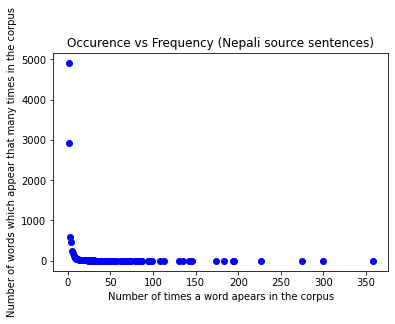

In [9]:
import string

dict_nepali = {}

for translation in translations:
    nepali_transaltions = translation.original.split()
    for word in nepali_transaltions:
        if len(word) > 1:
            word = word.translate(str.maketrans({a:None for a in string.punctuation}))

            if word in dict_nepali:
                dict_nepali[word] = 1 + dict_nepali[word]
            else: 
                dict_nepali[word] = 1

# for word in dict_nepali:
#     if dict_nepali[word] == 1:
#         print(word)

dict_occ_to_freq = {}

for word in dict_nepali:
    if dict_nepali[word] in dict_occ_to_freq:
        dict_occ_to_freq[dict_nepali[word]] = 1 + dict_occ_to_freq[dict_nepali[word]]
    else: 
        dict_occ_to_freq[dict_nepali[word]] = 1


x = []
y = []

for occ in dict_occ_to_freq:
    x.append(occ)
    y.append(dict_occ_to_freq[occ])

# print(dict_occ_to_freq[1])

plt.xlabel('Number of times a word apears in the corpus') 
plt.ylabel('Number of words which appear that many times in the corpus') 
plt.title('Occurence vs Frequency (Nepali source sentences)')
plt.scatter(x, y, color= "blue") 
plt.show()  

In [0]:
rare_threshold = 2
for translation in translations:
    translation_source = translation.original.split()
    translation_trans = translation.translation.split()

    rare_source_num = 0
    for word in translation_source:
        if len(word) > 1:
            word = word.translate(str.maketrans({a:None for a in string.punctuation}))
            if dict_nepali[word] <= rare_threshold:
                rare_source_num += 1

    rare_translation_num = 0
    for word in translation_trans:
        if len(word) > 1:
            word = word.translate(str.maketrans({a:None for a in string.punctuation}))
            if dict_english[word] <= rare_threshold:
                rare_translation_num += 1

    # if rare_source_num < 0 or rare_translation_num < 0:
    #     print(str([rare_source_num, rare_translation_num]))
    # print(str([rare_source_num, rare_translation_num, rare_source_num - rare_translation_num]))
    translation.score[5:8] = [rare_source_num, rare_translation_num, rare_source_num - rare_translation_num]

Repetition Analysis

In [0]:
def longestRepeatedSubstring(str): 
    n = len(str) 
    LCSRe = [[0 for x in range(n + 1)]  for y in range(n + 1)] 
    res_length = 0
    index = 0

    for i in range(1, n + 1): 
        for j in range(i + 1, n + 1): 
            if (str[i - 1] == str[j - 1] and
                LCSRe[i - 1][j - 1] < (j - i)): 
                LCSRe[i][j] = LCSRe[i - 1][j - 1] + 1
                if (LCSRe[i][j] > res_length): 
                    res_length = LCSRe[i][j] 
                    index = max(i, index)                 
            else: 
                LCSRe[i][j] = 0
    # res = ""
    # if (res_length > 0): 
    #     for i in range(index - res_length + 1, 
    #                                 index + 1): 
    #         res = res + str[i - 1] 
    
    return res_length



In [0]:
for translation in translations:
    repetition_score_en = longestRepeatedSubstring(translation.translation)
    repetition_score_ne = longestRepeatedSubstring(translation.original)
    translation.score[8] = repetition_score_en
    translation.score[9] = repetition_score_ne

In [0]:
rejected_sentences = open("analysis/rejected_sentences_in_"+dataSet+".data", "w")
accepted_sentences = open("analysis/accepted_sentences_in_"+dataSet+".data", "w")

for translation in translations:  
        if translation.score[4] > 15:
            accepted_sentences.write("Original = " + translation.original)
            accepted_sentences.write("Reference = " + translation.reference)
            accepted_sentences.write("Translation = " + translation.translation)
            accepted_sentences.write("Sentence BLEU = " + str(translation.score[4]) + " \n")
        else:
            rejected_sentences.write("Original = " + translation.original)
            rejected_sentences.write("Reference = " + translation.reference)
            rejected_sentences.write("Translation = " + translation.translation)
            rejected_sentences.write("Sentence BLEU = " + str(translation.score[4]) + "\n")


rejected_sentences.close()
accepted_sentences.close()
            

Generate backward model scores

In [14]:
!fairseq-generate \
    data-bin/wiki_ne_en_bpe5000/ \
    --source-lang en --target-lang ne \
    --path $bw_model \
    --beam 5 --lenpen 1.2 \
    --gen-subset $dataSet \
    --remove-bpe=sentencepiece \
    --sacrebleu > analysis/fairseqGenerate.data

storeTranslationStatistics()

  0% 0/13 [00:00<?, ?it/s]/pytorch/aten/src/ATen/native/BinaryOps.cpp:66: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


In [0]:
id_to_translation = {}

for index in range(len(translations)):
    if translations[index].trn_id in id_to_translation:
        id_to_translation[translations[index].trn_id].append(index)
    else:
        id_to_translation[translations[index].trn_id] = [index]

NMT_ground_truth = open("analysis/ground_truth_sentences.data", "r")
NMT_output = open("analysis/translated_sentences.data", "r")
NMT_original = open("analysis/original_sentences.data", "r")
Sentence_stats = open("analysis/logprob_statistics.data", "r")

files = [NMT_ground_truth, NMT_output, NMT_original, Sentence_stats]

for lines in zip_longest(*files, fillvalue=''):
    reference, translation, original, stats = lines
    curr_id = float(stats.strip("\n").split(" ")[-1])
    for index in id_to_translation[curr_id]:
        translations[index].score[11] = float(stats.strip("\n").split(" ")[-2])

NMT_ground_truth.close()
NMT_output.close()
NMT_original.close()
Sentence_stats.close()

Generate LM scores

In [18]:
import fastBPE

bpe = fastBPE.fastBPE("language_models/lm/bpe32k.code")
translation_text = [translation.translation for translation in translations]
bpe_text = bpe.apply(translation_text)

bpe_translations = open("analysis/bpe_translations.data", "w")
bpe_translations.writelines(bpe_text)
bpe_translations.close()

preprocessCommand = dataSet + "pref"
!fairseq-preprocess \
    --only-source \
    --srcdict "language_models/lm/dict.data" \
    --$preprocessCommand "analysis/bpe_translations.data" \
    --destdir "analysis/preprocessed_translations" \
    --workers 20

!fairseq-eval-lm analysis/preprocessed_translations \
    --path $lm_model \
    --batch-size 128 \
    --max-tokens 1024 \
    --output-word-probs \
    --sample-break-mode eos \
    --gen-subset $dataSet > analysis/translation_lm_score.data

Namespace(align_suffix=None, alignfile=None, bpe=None, cpu=False, criterion='cross_entropy', dataset_impl='mmap', destdir='analysis/preprocessed_translations', empty_cache_freq=0, fp16=False, fp16_init_scale=128, fp16_scale_tolerance=0.0, fp16_scale_window=None, joined_dictionary=False, log_format=None, log_interval=1000, lr_scheduler='fixed', memory_efficient_fp16=False, min_loss_scale=0.0001, no_progress_bar=False, nwordssrc=-1, nwordstgt=-1, only_source=True, optimizer='nag', padding_factor=8, seed=1, source_lang=None, srcdict='language_models/lm/dict.data', target_lang=None, task='translation', tensorboard_logdir='', testpref=None, tgtdict=None, threshold_loss_scale=None, thresholdsrc=0, thresholdtgt=0, tokenizer=None, trainpref=None, user_dir=None, validpref='analysis/bpe_translations.data', workers=20)
| [None] Dictionary: 35879 types
| [None] analysis/bpe_translations.data: 2559 sents, 55047 tokens, 1.64% replaced by <unk>
| Wrote preprocessed data to analysis/preprocessed_trans

In [0]:
import string
def numDotandSemicolon(string):
  return str(string).count(":") + str(string).count(".")
def numBar(string):
  return str(string).count("।")

In [0]:
for translation in translations:
    translation.score[13] = numDotandSemicolon(translation.translation)
    translation.score[14] = numBar(translation.original)
    translation.score[15] = translation.score[14]-translation.score[13]

In [0]:
#n = the 'n'-gram. Ex. Tri-gram => n = 3
def ngramCount(string, n):
    max_freq = 0
    ngram_dict = {}
    string_arr = string.split()
    length = n
    while n <= len(string_arr):
        curr_window = str(string_arr[n-length:n])
        if curr_window in ngram_dict:
            ngram_dict[curr_window] += 1
        else:
            ngram_dict[curr_window] = 1
        max_freq = max(max_freq, ngram_dict[curr_window])
        n += 1
    return max_freq

for translation in translations:
    translation.score[16] = ngramCount(translation.translation, 1)
    translation.score[17] = ngramCount(translation.translation, 2)
    translation.score[18] = ngramCount(translation.translation, 3)

In [0]:
for translation in translations:
    translation.score[19] = len(translation.translation)
    translation.score[20] = len(translation.original)
    translation.score[21] = float(len(translation.original))/float(len(translation.translation))

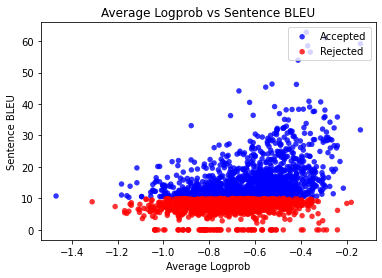

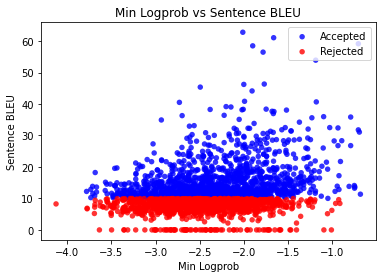

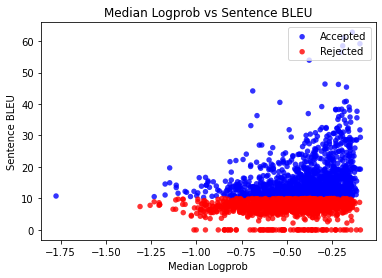

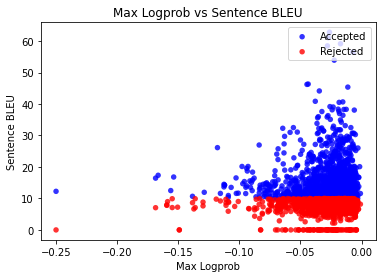

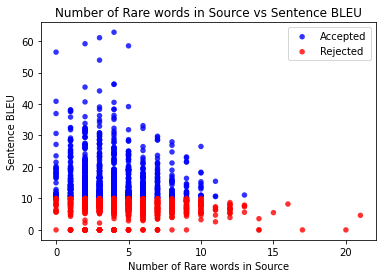

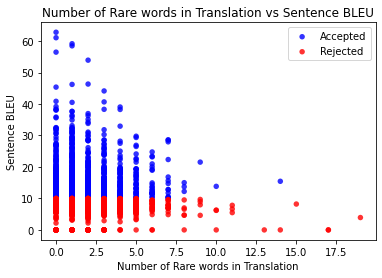

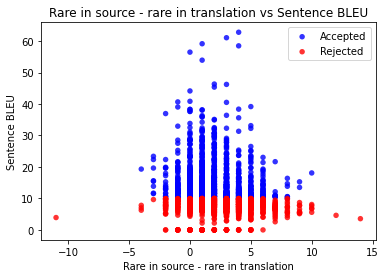

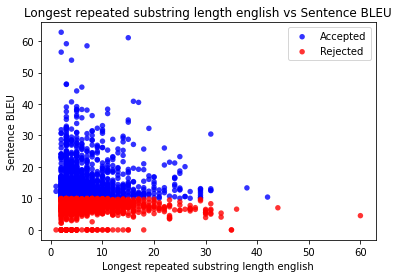

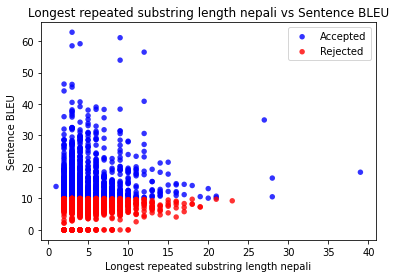

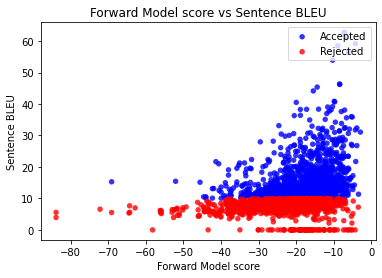

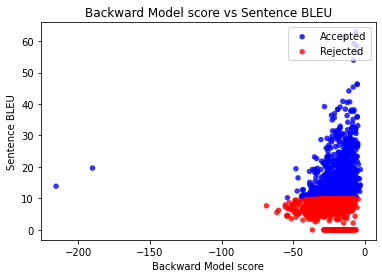

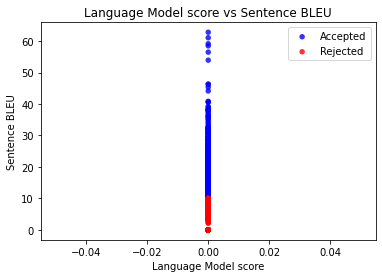

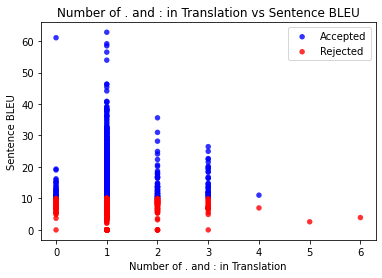

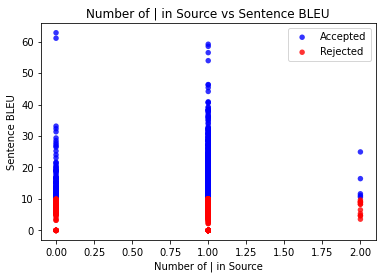

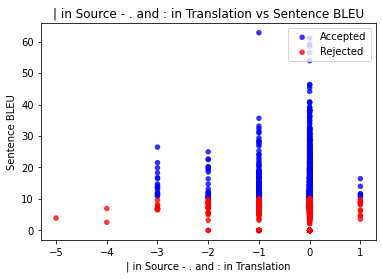

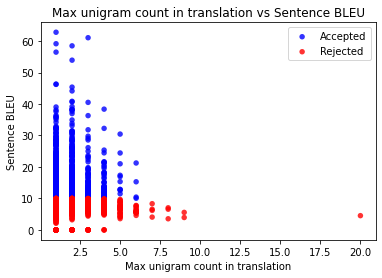

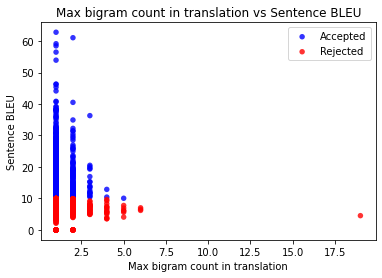

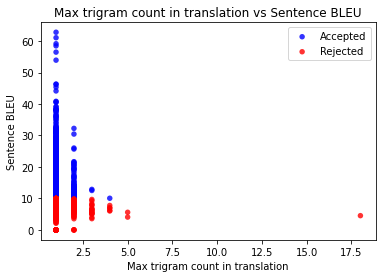

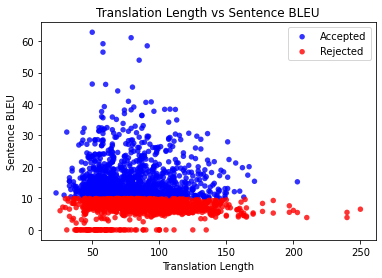

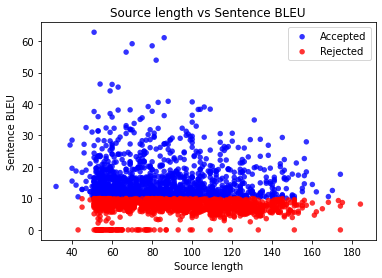

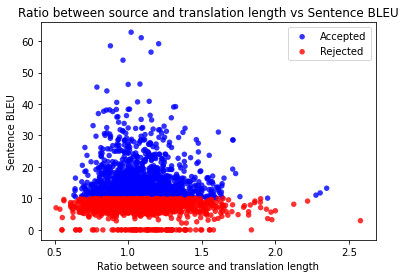

In [0]:
acceptedThreshold = 10

index_to_label = {0: "Average Logprob", 1: "Min Logprob", 2: "Median Logprob", 
                  3: "Max Logprob", 5: "Number of Rare words in Source", 
                  6: "Number of Rare words in Translation", 7: "Rare in source - rare in translation", 
                  8: "Longest repeated substring length english", 9: "Longest repeated substring length nepali",
                  10: "Forward Model score", 11: "Backward Model score", 12: "Language Model score", 
                  13: "Number of . and : in Translation", 14:"Number of | in Source",
                  15:"| in Source - . and : in Translation", 16: "Max unigram count in translation", 
                  17: "Max bigram count in translation", 18: "Max trigram count in translation", 
                  19: "Translation Length", 20: "Source length", 21: "Ratio between source and translation length"}
indices = [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]

for i in indices:
    accepted_set_stats = [[],[]]
    rejected_set_stats = [[],[]]
    for translation in translations:  
        if translation.score[4] > acceptedThreshold:
            accepted_set_stats[0].append(translation.score[i])
            accepted_set_stats[1].append(translation.score[4])
        else:
            rejected_set_stats[0].append(translation.score[i])
            rejected_set_stats[1].append(translation.score[4])

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    ax.scatter(accepted_set_stats[0], accepted_set_stats[1], alpha=0.8, c="blue", edgecolors='none', s=30, label="Accepted")
    ax.scatter(rejected_set_stats[0], rejected_set_stats[1], alpha=0.8, c="red", edgecolors='none', s=30, label="Rejected")

    plt.xlabel(index_to_label[i]) 
    plt.ylabel('Sentence BLEU') 
    plt.title(index_to_label[i] + ' vs Sentence BLEU')
    plt.legend(loc=1)
    plt.show()

Current list of features - 

```
0: Average Logprob

1: Min Logprob

2: Median Logprob 

3: Max Logprob

5: Number of Rare words in Source

6: Number of Rare words in Translation

7: Rare in source - rare in translation

10: Forward Model score [P(T|S)]

11: Backward Model score [P(S|T)]

12: Language Model score  [P(T)]

13: Number of . and : in Translation

14: Number of | in Source

15: | in Source - . and : in Translation

16: Max unigram count in translation

17: Max bigram count in translation

18: Max trigram count in translation

19: Translation Length

20: Source length

21: Ratio between source and translation length
```

Total Features = 19

In [0]:
#write dataset for classification

featureList = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
######DON"T USE INDEX 4 FOR TRAINING - THATS THE SENTENCE BLEU SCORE I.E. LABEL ITSELF#######

sentenceFile = open("ClassificationDataset/"+str(acceptedThreshold)+"BLEU/"+dataSet+"/sentences.data", "w")
featureFile = open("ClassificationDataset/"+str(acceptedThreshold)+"BLEU/"+dataSet+"/features.data", "w")
resultFile = open("ClassificationDataset/"+str(acceptedThreshold)+"BLEU/"+dataSet+"/result.data", "w")

for translation in translations:
    currFeatures = []
    for idx in featureList:
        currFeatures.append(translation.score[idx])
    currFeatures = str(currFeatures)[1:-1]+"\n"
    result = int(translation.score[4] > acceptedThreshold)

    sentenceFile.write(translation.original)
    sentenceFile.write(translation.reference)
    sentenceFile.write(translation.translation)
    sentenceFile.write(str(translation.score[4])+"\n")

    featureFile.write(currFeatures)

    resultFile.write(str(result) + "\n")


sentenceFile.close()
featureFile.close()
resultFile.close()
